This notebook sets up a SFINCS model for the area of interest, the . 
1. Standard SFINCS model.
2. SFINCS model with added dikes
3. SFINCS model with dikes and breaches in dikes.   

In [9]:
from hydromt_sfincs import SfincsModel
from hydromt.config import configread
from hydromt.log import setuplog
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import pandas as pd
import datetime
from hydromt_sfincs import utils
import xarray as xr
from shapely.geometry import Point



USER INPUT

Set the model directory.
Set start and end times 
Select the data sources. Here we use local data for bathymetry and topography, which are specified in the data.yml file. 
Water level forcings are received from a local tide gauge tide gauge. Provide coordinates

In [18]:
# Model directory
main_dir = r"c:\Users\winter_ga\Offline_data\projects\InterTwin\FDZ_model"
run_name = "model_20m_final"      

# Start and end times
tstart= "20231015 070000"
tstop= "20231023 000000"

# model resolution
res = 20

mask_file = r"c:\Users\winter_ga\Offline_data\projects\InterTwin\FDZ_model\mask_25833.geojson"

# water levels
wl_csv = r"c:\Users\winter_ga\Offline_data\projects\InterTwin\Wasserstaende\pegelonline-barhft-W-20231015-20231023.csv"
# offset of tide gauge from local datum
waterlevel_offset = -498

# INitial water level
inifile = r"c:\Users\winter_ga\Offline_data\projects\InterTwin\Geodaten\zsini_regridded_20m_final.tif"

logger = setuplog()
opt = configread(os.path.join(main_dir,"fdz_base.yml"))

# Bathymetry and topography data in data.yml
data_libs=r"c:\Users\winter_ga\Offline_data\projects\InterTwin\FDZ_model\data.yml"
datasets_dep = [{"elevtn": "MVtopo_masked", "zmin": 0.01},{"elevtn": "ELC_INSPIRE"},{"elevtn": "merit_hydro"}]

# Water level boundary point coordinates (Barhoeft)
x = [372368.1]
y = [6033653.6]
# https://www.pegelonline.wsv.de/webservices/rest-api/v2/stations/09227288-8c72-4b12-88fe-8765d1b2b400.json?includeTimeseries=true
# {
#   "uuid": "09227288-8c72-4b12-88fe-8765d1b2b400",
#   "number": "9650040",
#   "shortname": "BARHÖFT",
#   "longname": "BARHÖFT",
#   "agency": "STANDORT STRALSUND",
#   "longitude": 13.032221032802543,
#   "latitude": 54.43453931311291,
#   "water": {
#     "shortname": "OSTSEE",
#     "longname": "OSTSEE"
#   },
#   "timeseries": [
#     {
#       "shortname": "W",
#       "longname": "WASSERSTAND ROHDATEN",
#       "unit": "cm",
#       "equidistance": 1,
#       "gaugeZero": {
#         "unit": "m. ü. NHN",
#         "value": -4.977,
#         "validFrom": "2019-11-01"
#       }
#     }
#   ]
# }

# Observation points for model validation
d = {'Station': ["Barhoeft","Barth","Althagen"], 
     'geometry': [
         Point(371100.0, 6034300.0), 
         Point(352691.1, 6027443.5),
         Point(332296.2, 6027473.9),
         ]}

dike_file = r"c:\Users\winter_ga\Offline_data\projects\InterTwin\Geodaten\all_dikes.gpkg"

breach_locations = {'Location': ["1","2"], 
     'geometry': [
         Point(342608.0, 6030840.0), 
         Point(344915.1, 6031933.0),
         ]}


2025-04-07 18:51:14,814 - hydromt - log - INFO - HydroMT version: 0.10.1


Generate SFINCS model and set
- Timing
- Resolution
- Mask
- Depth
- Roughness
- Initial water level. This is important in this use case because some if the land is below zero. Hence we prepared an initial water level map with zero in the water bodies and -1 over land.

In [25]:
# Make model
sf = SfincsModel(data_libs=data_libs,root=os.path.join(main_dir,run_name), mode='w+', logger=logger)

sf.setup_config(
    tref= tstart,
    tstart= tstart,
    tstop= tstop,
    dtout= 10400.0,
    dthisout= 600.0,
    dtmaxout= 259200.0,
    zsini=-1.0,
    tspinup=86400,
    
)
sf.setup_grid_from_region(
    region = {'geom': mask_file},
    res = res,
    rotated = False,
    crs = 25833,
)
# sf.setup_dep(**opt['setup_dep'])
# sf.setup_subgrid(**opt['setup_dep'])

# Add depth information to modelgrid based on these chosen datasets
dep = sf.setup_dep(datasets_dep=datasets_dep)

sf.setup_mask_active(
    include_mask= mask_file,
    zmax= -50.0
)
sf.setup_mask_bounds(
    btype="waterlevel",
    zmax= 0
)


# dep = sf.setup_subgrid(
#     datasets_dep=datasets_dep,
#     # manning_land=0.04,
#     # manning_sea=manning_sea, 
#     # rgh_lev_land=0.0,
#     write_dep_tif=True,
#     write_man_tif=True,
#     nr_subgrid_pixels=4,
#     )

# set up roughness 
sf.setup_manning_roughness(
    manning_land=0.04,
    manning_sea=0.02,
    rgh_lev_land=0,  # the minimum elevation of the land
)

# set initial water level to zero, except over land set it to -1
ini_ds = xr.open_dataset(inifile, engine="rasterio")
ini_ds["zsini"] = ini_ds["band_data"]
ini_ds = ini_ds.drop(["band_data"])
sf.set_states(data=ini_ds["zsini"])
sf.set_config("inifile","sfincs.ini")

sf.config

2025-04-07 18:55:06,059 - hydromt - data_catalog - INFO - Parsing data catalog from c:\Users\winter_ga\Offline_data\projects\InterTwin\FDZ_model\data.yml
2025-04-07 18:55:06,071 - hydromt - model_api - WARNING - Model dir already exists and files might be overwritten: c:\Users\winter_ga\Offline_data\projects\InterTwin\FDZ_model\model_20m_final\gis.
2025-04-07 18:55:06,072 - hydromt - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.1.0).
2025-04-07 18:55:06,074 - hydromt - geodataframe - INFO - Reading  vector data from c:\Users\winter_ga\Offline_data\projects\InterTwin\FDZ_model\mask_25833.geojson
2025-04-07 18:55:06,093 - hydromt - rasterdataset - INFO - Reading MVtopo_masked raster data from C:\Users\winter_ga\Offline_data\projects\InterTwin\FDZ_model\mv_masked_clipped.tif
2025-04-07 18:55:06,120 - hydromt - rasterdataset - INFO - Reading ELC_INSPIRE raster data from C:\Users\winter_ga\Offline_data\projects\InterTwin\FDZ_model\ELC_INSPIRE\Baltic_Sea_Bathy.tif
202

{'mmax': 2601,
 'nmax': 1849,
 'dx': 20,
 'dy': 20,
 'x0': 320819.0,
 'y0': 6011448.0,
 'rotation': 0,
 'latitude': 0.0,
 'tref': '20231015 070000',
 'tstart': '20231015 070000',
 'tstop': '20231023 000000',
 'tspinup': 86400,
 'dtout': 10400.0,
 'dthisout': 600.0,
 'dtrstout': 0.0,
 'dtmaxout': 259200.0,
 'trstout': -999.0,
 'dtwnd': 1800.0,
 'alpha': 0.5,
 'theta': 1.0,
 'huthresh': 0.01,
 'manning': 0.04,
 'zsini': -1.0,
 'qinf': 0.0,
 'rhoa': 1.25,
 'rhow': 1024.0,
 'dtmax': 60.0,
 'advection': 1,
 'baro': 1,
 'pavbnd': 0,
 'gapres': 101200.0,
 'stopdepth': 100.0,
 'crsgeo': 0,
 'btfilter': 60.0,
 'viscosity': 1,
 'inputformat': 'bin',
 'outputformat': 'net',
 'cdnrb': 3,
 'cdwnd': [0.0, 28.0, 50.0],
 'cdval': [0.001, 0.0025, 0.0015],
 'epsg': 25833,
 'depfile': 'sfincs.dep',
 'mskfile': 'sfincs.msk',
 'indexfile': 'sfincs.ind',
 'manningfile': 'sfincs.man',
 'inifile': 'sfincs.ini'}

Add boundary point and water level at the boundary

,geometry
1,POINT (372368.1 6033653.6)


,1
time,
2023-10-15 00:00:00,-0.04
2023-10-15 00:01:00,-0.04
2023-10-15 00:02:00,-0.05
2023-10-15 00:03:00,-0.05
2023-10-15 00:04:00,-0.06
...,...
2023-10-23 23:55:00,0.36
2023-10-23 23:56:00,0.36
2023-10-23 23:57:00,0.36


(<Figure size 600x300 with 1 Axes>,
 [<Axes: title={'center': 'SFINCS waterlevel forcing (bzs)'}, ylabel='waterlevel\n[m+ref]'>])

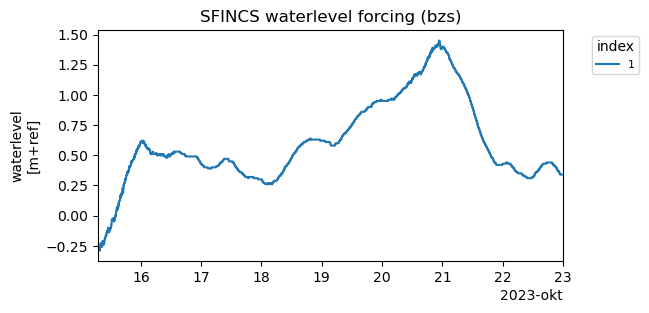

In [26]:
# set up water level boundary point (Barhoeft)
# add to Geopandas dataframe as needed by HydroMT
pnts = gpd.points_from_xy(x, y)
index = [1]  # NOTE that the index should start at one
bnd = gpd.GeoDataFrame(index=index, geometry=pnts, crs=sf.crs)

display(bnd)

# add waterlevel forcing
# we use measured timeseries
df = pd.read_csv(wl_csv, header=0,delimiter=";")
df=df.rename(columns={"timestamp":"time", "value":1})
df[1]=pd.to_numeric(df[1])

time = pd.to_datetime(df["time"])

# and the actual water levels, in this case for input location 1 a water level rising from 0 to 2 meters and back to 0:
bzs = ((df[1]+waterlevel_offset)/100).to_list()

bzspd = pd.DataFrame(index=time, columns=index, data=bzs)
display(bzspd)

# Actually add it to the SFINCS model class:
sf.setup_waterlevel_forcing(timeseries=bzspd, locations=bnd, buffer=1000)

# NOTE: the waterlevel forcing data is now stored in the sf.forcing dictionary
sf.forcing.keys()
sf.plot_forcing(fn_out="forcing.png")

Add observation points

In [27]:
# setup observation points 
gdf = gpd.GeoDataFrame(d, crs="EPSG:25833")
display(gdf)

sf.setup_observation_points(
    locations=gdf, merge=False
)
    

,Station,geometry
0,Barhoeft,POINT (371100 6034300)
1,Barth,POINT (352691.1 6027443.5)
2,Althagen,POINT (332296.2 6027473.9)


2025-04-07 18:55:40,087 - hydromt - sfincs - INFO - Writing model data to c:\Users\winter_ga\Offline_data\projects\InterTwin\FDZ_model\model_20m_final
2025-04-07 18:55:40,194 - hydromt - sfincs - INFO - Write raster file(s) for grid to 'gis' subfolder
2025-04-07 18:55:40,831 - hydromt - sfincs - INFO - Write geom files
2025-04-07 18:55:40,834 - hydromt - sfincs - INFO - Write vector file(s) for geoms to 'gis' subfolder
2025-04-07 18:55:40,921 - hydromt - sfincs - INFO - Write forcing files
2025-04-07 18:55:40,968 - hydromt - sfincs - INFO - Write vector file(s) for forcing.bzs to 'gis' subfolder
2025-04-07 18:55:41,242 - hydromt - sfincs - INFO - Write raster file(s) for states to 'gis' subfolder
2025-04-07 18:55:41,244 - hydromt - sfincs - WARNING - Variable states.zsini has more than 2 dimensions: skipping.


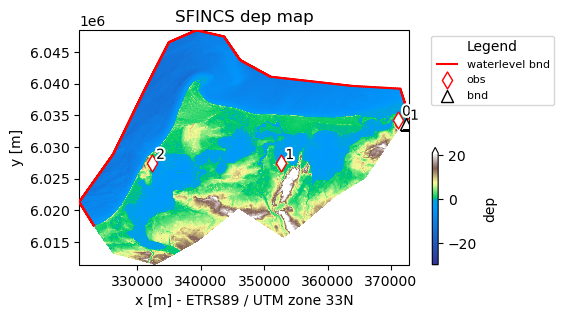

In [28]:
# Write results
sf.write()
sf.plot_basemap()
plt.savefig(os.path.join(main_dir,run_name,'basemap.png'))

Create model with dikes

2025-04-07 18:55:46,255 - hydromt - geodataframe - INFO - Reading  vector data from c:\Users\winter_ga\Offline_data\projects\InterTwin\Geodaten\all_dikes.gpkg
2025-04-07 18:55:46,344 - hydromt - geodataframe - WARNING - GeoDataFrame : CRS from data catalog does not match CRS of data. The original CRS will be used. Please check your data catalog.
2025-04-07 18:55:47,492 - hydromt - model_api - WARNING - Model dir already exists and files might be overwritten: c:\Users\winter_ga\Offline_data\projects\InterTwin\FDZ_model\model_20m_final_dikes\gis.
2025-04-07 18:55:47,495 - hydromt - sfincs - INFO - Writing model data to c:\Users\winter_ga\Offline_data\projects\InterTwin\FDZ_model\model_20m_final_dikes
2025-04-07 18:55:47,605 - hydromt - sfincs - INFO - Write raster file(s) for grid to 'gis' subfolder
2025-04-07 18:55:48,240 - hydromt - sfincs - INFO - Write geom files
2025-04-07 18:55:49,275 - hydromt - sfincs - INFO - Write vector file(s) for geoms to 'gis' subfolder
2025-04-07 18:55:49,

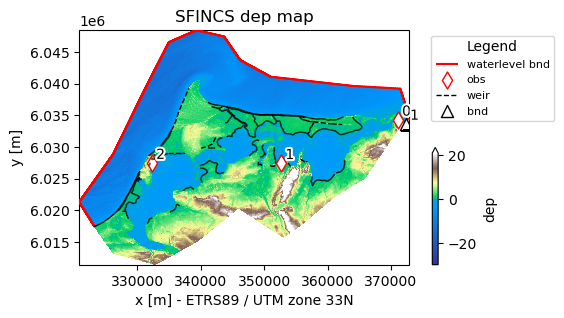

In [29]:
# Add dikes
# HydroMT function: get geodataframe from dike_file
gdf_floodwall = sf.data_catalog.get_geodataframe(
    dike_file, geom=sf.region, crs=sf.crs
)

# Add floodwall attributes to geodataframe
if (gdf_floodwall.geometry.type == "MultiLineString").any():
    gdf_floodwall = gdf_floodwall.explode()

# par1 is the overflow coefficient for weirs
gdf_floodwall["par1"] = 0.6

# HydroMT function: create floodwall
sf.setup_structures(structures=gdf_floodwall, stype="weir", merge=False)

run_name_dikes = run_name+"_dikes"      

sf.set_root(root=os.path.join(main_dir,run_name_dikes), mode="w+")
sf.write()
sf.plot_basemap()
plt.savefig(os.path.join(main_dir,run_name_dikes,'basemap.png'))


Remove line segments near breach from dike line features

2025-04-07 19:11:00,484 - hydromt - model_api - WARNING - Replacing geom: weir
2025-04-07 19:11:00,500 - hydromt - model_api - WARNING - Model dir already exists and files might be overwritten: c:\Users\winter_ga\Offline_data\projects\InterTwin\FDZ_model\model_20m_final_dikes_withbreaches\gis.
2025-04-07 19:11:00,502 - hydromt - sfincs - INFO - Writing model data to c:\Users\winter_ga\Offline_data\projects\InterTwin\FDZ_model\model_20m_final_dikes_withbreaches
2025-04-07 19:11:00,627 - hydromt - sfincs - INFO - Write raster file(s) for grid to 'gis' subfolder
2025-04-07 19:11:01,300 - hydromt - sfincs - INFO - Write geom files
2025-04-07 19:11:02,434 - hydromt - sfincs - INFO - Write vector file(s) for geoms to 'gis' subfolder
2025-04-07 19:11:02,660 - hydromt - sfincs - INFO - Write forcing files
2025-04-07 19:11:02,700 - hydromt - sfincs - INFO - Write vector file(s) for forcing.bzs to 'gis' subfolder
2025-04-07 19:11:02,871 - hydromt - sfincs - INFO - Write raster file(s) for states

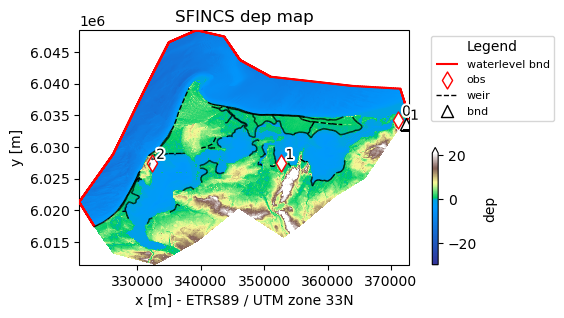

In [53]:
# find dike breaches
s = gpd.GeoSeries(gdf_floodwall.geometry)
breach_ids = s.sindex.nearest(breach_locations["geometry"])
gdf_floodwall_breached=gdf_floodwall.drop(index=breach_ids[1])

# par1 is the overflow coefficient for weirs
gdf_floodwall_breached["par1"] = 0.6

# HydroMT function: create floodwall
sf.setup_structures(structures=gdf_floodwall_breached, stype="weir", merge=False)

run_name_dikes = run_name+"_dikes_withbreaches"      

sf.set_root(root=os.path.join(main_dir,run_name_dikes), mode="w+")
sf.write()
sf.plot_basemap()
plt.savefig(os.path.join(main_dir,run_name_dikes,'basemap.png'))


Alternative: not remove but lower dikes near breaches


2025-04-07 19:18:51,801 - hydromt - model_api - WARNING - Replacing geom: weir
2025-04-07 19:18:51,803 - hydromt - model_api - WARNING - Model dir already exists and files might be overwritten: c:\Users\winter_ga\Offline_data\projects\InterTwin\FDZ_model\model_20m_final_dikes_overtopping\gis.
2025-04-07 19:18:51,804 - hydromt - sfincs - INFO - Writing model data to c:\Users\winter_ga\Offline_data\projects\InterTwin\FDZ_model\model_20m_final_dikes_overtopping
2025-04-07 19:18:51,917 - hydromt - sfincs - INFO - Write raster file(s) for grid to 'gis' subfolder
2025-04-07 19:18:52,610 - hydromt - sfincs - INFO - Write geom files
2025-04-07 19:18:53,710 - hydromt - sfincs - INFO - Write vector file(s) for geoms to 'gis' subfolder
2025-04-07 19:18:53,934 - hydromt - sfincs - INFO - Write forcing files
2025-04-07 19:18:53,972 - hydromt - sfincs - INFO - Write vector file(s) for forcing.bzs to 'gis' subfolder
2025-04-07 19:18:54,136 - hydromt - sfincs - INFO - Write raster file(s) for states t

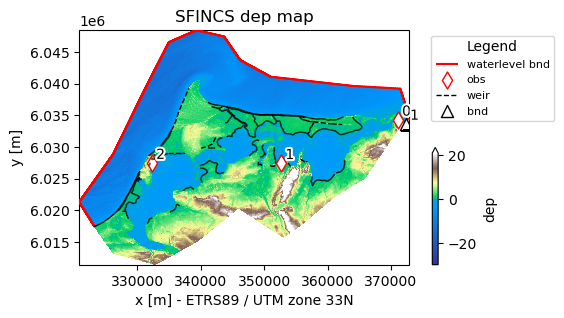

In [60]:
# find dike breaches
s = gpd.GeoSeries(gdf_floodwall.geometry)
breach_ids = s.sindex.nearest(breach_locations["geometry"])
gdf_floodwall_overtopped=gdf_floodwall.copy()

gdf_floodwall_overtopped["z"].loc[breach_ids[1]] = 0.8  

# par1 is the overflow coefficient for weirs
gdf_floodwall_overtopped["par1"] = 0.6


# HydroMT function: create floodwall
sf.setup_structures(structures=gdf_floodwall_overtopped, stype="weir", merge=False)

run_name_dikes = run_name+"_dikes_overtopping"      

sf.set_root(root=os.path.join(main_dir,run_name_dikes), mode="w+")
sf.write()
sf.plot_basemap()
plt.savefig(os.path.join(main_dir,run_name_dikes,'basemap.png'))


In [61]:
gdf_floodwall_overtopped.loc[breach_ids[1]]

,id,idx,z,geometry,par1
1389,4.0,213.0,0.8,"LINESTRING (342611.245 6030854.74, 342606.128 ...",0.6
1551,2.0,169.0,0.8,"LINESTRING (344915.884 6031946.722, 344915.956...",0.6
